In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import pysindy as ps
from torch.utils.data import DataLoader, TensorDataset
from functions import Solution, LV
from models import Autoencoder, integrator, network
from dynamical_models import PredatorPrey
import torch.nn.functional as F

In [37]:
b1, b2, a12, a21 = 2/3, 1, 4/3, 1
h = 0.1
t = np.arange(0, 100, h)
n = len(t)
x0 = [1, 1.5]
xs, ys = Solution(LV, x0, t, [b1, b2, a12, a21])
tau = 15

sol = Solution(LV, x0, t, [b1, b2, a12, a21])
library = ps.PolynomialLibrary(degree=2)
model = ps.SINDy(feature_library=library,
                 optimizer=ps.STLSQ(threshold=0.05),
                 feature_names=["x", "y"])

model.fit(sol.T, t)
model.print()

LV_coefs = model.coefficients()

(x)' = 0.664 x + -1.329 x y
(y)' = -0.996 y + 0.996 x y


In [38]:
pp = PredatorPrey(args = [2/3, 1, 4/3, 1])
system = pp.f
X = odeint(system, x0, t, args = ())
x_input = X[:,0]
layer_dims = [2, 100, 40, 10, 2]
tstep_pred = 35

In [39]:
ode_model = integrator(tstep_pred, 0.1, system=system, init_params=np.zeros_like(LV_coefs))
encoder = network(layer_dims=layer_dims, activation= F.relu)
decoder = network(layer_dims=layer_dims[::-1], activation=F.relu)

optim_enc = torch.optim.Adam(encoder.parameters(), lr = 1e-3)
optim_ode = torch.optim.Adam(ode_model.parameters(), lr = 1e-3)
loss_fn = nn.MSELoss()

In [40]:
v1 = np.array(xs[0: n - 2*tau]) #x(t)
v2 = np.array(xs[tau: n - tau]) #x(t + τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])

v = torch.tensor(np.array([v1, v2]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2]), dtype=torch.float32, requires_grad=True).T
dataset = TensorDataset(v, dvdt)
dataloader = DataLoader(dataset, batch_size=1500, shuffle=False)

In [41]:
torch.manual_seed(123)

In [42]:
sindyae = Autoencoder(tau, ode_model=ode_model, loss_fn=loss_fn, optim_enc=optim_enc, optim_ode=optim_ode, tstep_pred=tstep_pred,
                                  encoder=encoder, decoder=decoder,
                                  l={'x0':1, 'cons': 1, 'l1': 1e-1, 'recon': 1e-1, 'x_dot': 1e-1, 'v_dot': 1e-1})

In [43]:
for epoch in range(100):
    total_loss = 0
    for v_batch, dvdt_batch in dataloader:
        Loss = sindyae.loss(v_batch, dvdt_batch)
        Loss.backward()
        optim_enc.step()
        optim_ode.step()
        optim_enc.zero_grad()
        optim_ode.zero_grad()
        total_loss += Loss.item() 
    average_loss = total_loss / len(dataloader)
    if (epoch+1) % 10== 0:
         print(f"Epoch [{epoch+1}/{100}], Loss: {average_loss:.4f}")

Epoch [10/100], Loss: 1.7999
Epoch [20/100], Loss: 1.2115
Epoch [30/100], Loss: 1.2434
Epoch [40/100], Loss: 1.7414
Epoch [50/100], Loss: 1.7493
Epoch [60/100], Loss: 1.4167
Epoch [70/100], Loss: 1.2158
Epoch [80/100], Loss: 1.1593
Epoch [90/100], Loss: 1.1672
Epoch [100/100], Loss: 1.1949


In [44]:
encoder.eval() 
ode_model.eval()
latent_variables = encoder(v)
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()

(x)' = -10963.485 1 + -9895.200 x + 48518.922 y + 1122.580 x^2 + -9082.874 x y + 17859.133 y^2
(y)' = -2308.803 1 + -2083.736 x + 10217.652 y + 236.503 x^2 + -1913.194 x y + 3760.781 y^2


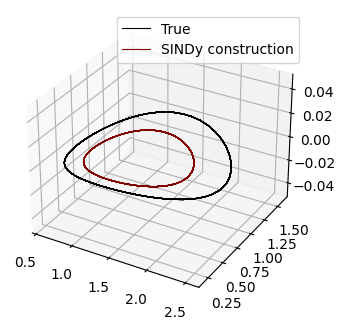

In [45]:
latent_library = ps.PolynomialLibrary(degree = 2)
latent_model = ps.SINDy(feature_library=latent_library,
                        optimizer=ps.STLSQ(threshold=0.0),
                        feature_names=["x", "y"])
latent_model.fit(latent_variables.detach().numpy(), t[:len(latent_variables.detach().numpy())])
latent_model.print()
latent_coef = latent_model.coefficients()

latent_sol = odeint(system, latent_variables[0].detach().numpy(), t, args = (latent_coef,))
fig = plt.figure(figsize=(13, 13))
ax3d = fig.add_subplot(1, 3, 1, projection='3d')
ax3d.plot(X[:,0], X[:,1], lw = .8, color = "k", label = "True")
ax3d.plot(latent_sol[:,0], latent_sol[:,1], lw = .8, color ='maroon', label = "SINDy construction")
plt.legend()
plt.show()